# Interactive NDVI

In [1]:
import datetime
import geemap
import ee
from astral import LocationInfo
from astral.sun import sun

ee.Initialize()
bands = ['CMI_C01', 'CMI_C02', 'CMI_C03']


def set_coordinates(left, bottom, right, top):
    return ee.Geometry.BBox(left, bottom, right, top)


def applyScaleandOffset(image):
    
    band_list = image.select('CMI_C..').bandNames()

    scales = (band_list.map(lambda name: ee.String(name).cat('_scale'))).map(lambda band: image.getNumber(band))
    offsets = (band_list.map(lambda name: ee.String(name).cat('_offset'))).map(lambda band: image.getNumber(band))

    scaled = image.select('CMI_C..').multiply(ee.Image.constant(scales)).add(ee.Image.constant(offsets))

    return image.addBands(srcImg = scaled, overwrite = True)


def get_daytime(lat, lon):

    loc = LocationInfo(latitude=lat, longitude=lon)
    s = sun(loc.observer, date=datetime.date.today() - datetime.timedelta(days=1))
    
    if s['sunset'] <= s['sunrise']:
        s['sunset'] = s['sunset'] + datetime.timedelta(days=1)

    return (s['sunrise'].strftime(format="%Y-%m-%dT%H:%M:00"), s['sunset'].strftime(format="%Y-%m-%dT%H:%M:00"))


In [2]:
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(["CMI_C03", "CMI_C02"]).rename('NDVI')
    return image.addBands(ndvi)

def calculate_ndwi(image):

    nir = image.select("CMI_C03")
    red = image.select("CMI_C02")
    blue = image.select("CMI_C01")

    green = red.multiply(0.45).add(nir.multiply(0.1)).add(blue.multiply(0.45))
    ndwi = green.subtract(nir).divide(green.add(nir)).rename('NDWI')

    return image.addBands(ndwi)

In [7]:
def call_single_map(lat, lon, collection_name = 'NOAA/GOES/16/MCMIPC', bands=bands, radius=40000):

    goes_collection = ee.ImageCollection(collection_name)

    # Set the location of the ROI. USER INPUT REQUIRED.
    #roi = set_coordinates(coords['left'], coords['bottom'], coords['right'], coords['top'])
    roi = ee.Geometry.Point([lon, lat]).buffer(distance=radius)
    
    # Get the image collection for the given time period and location.
    date_start, date_end = get_daytime(lat, lon) #UPPER LEFT CORNER (smallest day duration)
    period = ee.DateRange(date_start, date_end)

    # Calculate the indexes
    #indexes = goes_collection.filterDate(period).select(bands).map(applyScaleandOffset).map(calculate_ndvi).map(calculate_ndwi).reduce(ee.Reducer.median()).clip(roi)
    indexes = goes_collection.filterDate(period).select(bands).map(applyScaleandOffset).map(calculate_ndvi).reduce(ee.Reducer.median()).clip(roi)

    # Split the map
    # Add the image to the map.
    ndviParams = {'bands': ['NDVI_median'],
                    'min': -1,
                    'max': 1,
                    'palette': ['blue', 'white', 'green']}

    colorbar_params = {
            'width': 4.0,
        'height': 0.3,
        'vmin': -1,
        'vmax': 1,
        'palette': ['blue', 'white', 'green'],
        'label': 'NDVI',
        'orientation': 'horizontal',
        'transparent': False,
    }

    
    ndwiParams = {'bands': ['NDWI_median'],
                'min': 0.0,
                'max': 1,
                'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

    colors = ndviParams['palette']
    vmin = ndviParams['min']
    vmax = ndviParams['max']

    colors2 = ndwiParams['palette']
    vmin2 = ndwiParams['min']
    vmax2 = ndwiParams['max']


    m = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
    m.setCenter(lon, lat, 10)

    m.addLayer(indexes, ndviParams, 'NDVI')
    m.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name="NDVI")
    geemap.save_colorbar('colorbar.png', **colorbar_params)
    #m.addLayer(indexes, ndwiParams, 'NDWI')
    #m.add_colorbar_branca(colors=colors2, vmin=vmin2, vmax=vmax2, layer_name="NDWI")

    #m.addLayerControl()

    return m

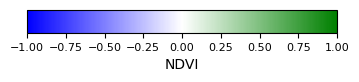

In [8]:
lat = 37.25
lon = -102.84


map2 = call_single_map(lat, lon)
map2.to_html(filename="html_NDVI.html", title='My Map', width='100%', height='880px')

In [25]:
map2

Map(center=[37.25, -102.84], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…